In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

$$
3x^2-4x+5
$$

In [2]:
def f(x):
    return 3 * x**2 - 4*x +5

In [3]:
f(3.0)

20.0

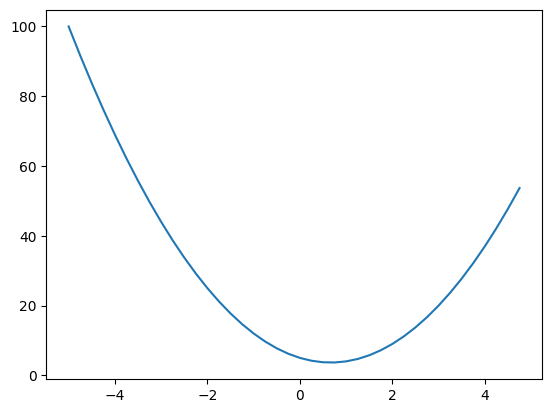

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys) # show parabola

What is the derivative of this function at any given input $x$?

In ML, we don't actually write out the derivatives for each function we use. Instead, we use a technique called automatic differentiation.

Derivatives tell us how a function changes as its input changes.
How does the slope of the function change as we move along the x-axis?

In [5]:
# How do you think $f$ changes when $x$ changes by a small amount $h$?
h = 0.001
x = 3.0
f(x+h) # the value of $f$ of $x$ plus a small amount, $h$.
f(x+h) - f(x) # the change in $f$ when $x$ changes by $h$.
(f(x+h) - f(x)) / h # we normalize by the run, $h$ (rise/run). This is just a numerical approximation of the slope.
# we have to make 

14.00300000000243

Adding complexity...

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
# Utility fn to print

from typing import Dict, Any


def p(obj: Any, indent: int = 0):
    if not isinstance(obj, Dict):
        print(" " * indent, obj)
        return

    max_len = max([len(k) for k in obj.keys()]) + 1
    for k, v in obj.items():
        print(f"{' ' * indent}{(k+':').ljust(max_len)}", end=" ")
        if isinstance(v, Dict):
            print()
            p(v, indent + 2)
        else:
            print(v)

Finding the derivative of a function with multiple inputs:

We find the derivative of $d$ w.r.t $a, b, c$ by taking the partial derivative of $d$ w.r.t each input.

In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0


def f(a, b, c):
    return a * b + c


def df_da(a, b, c, h):
    """
    Calculates the slope of d with respect to a, that is, the partial derivative of d with respect to a.
    Found by increasing a by a small amount, h, and seeing how much d changes, while keeping the other variables constant. Then normalizing by h to get the slope.
    """
    return (f(a + h, b, c) - f(a, b, c)) / h


def df_db(a, b, c, h):
    return (f(a, b + h, c) - f(a, b, c)) / h


def df_dc(a, b, c, h):
    return (f(a, b, c + h) - f(a, b, c)) / h


p(
    {
        "f(a, b, c)": f(a, b, c),
        "Slopes": {
            "Slope (a)": df_da(a, b, c, h),
            "Slope (b)": df_db(a, b, c, h),
            "Slope (c)": df_dc(a, b, c, h),
        },
    }
)

f(a, b, c): 4.0
Slopes:     
  Slope (a): -3.000000000010772
  Slope (b): 2.0000000000042206
  Slope (c): 0.9999999999976694


## Moving to Neural Networks

Neural networks are a series of functions composed together. That makes them rather large expressions.
That's why we use data structures to represent them.

In [9]:
from typing import Tuple, Set


class Value:
    def __init__(self, data, _children: Tuple = (), _op: str = "", label: str = ""):
        self.data = data
        self.grad = (
            0.0  # by default the gradient is 0: we assume it doesn't affect the output.
        )
        self._backward = (
            lambda: None
        )  # function that uses the chain rule to calculate the gradient
        self._prev: Set[Value] = set(_children)
        self._op: str = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), "ReLU")

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v: Value):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

In [10]:
from graphviz import Digraph


def trace(root: Value):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def uid(n: Value):
    return str(id(n))


def draw_dot(root: Value):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # left to right

    nodes, edges = trace(root)
    for n in nodes:
        n_uid = uid(n)
        # create rectangular node for each value
        dot.node(name=n_uid, label="{ %s |data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape="record")

        # if the node has an operation, create a node for the operation and link it to the value node
        if n._op:
            dot.node(name=n_uid + n._op, label=n._op)
            dot.edge(n_uid + n._op, n_uid)

    for n1, n2 in edges:
        n1_uid, n2_uid = map(uid, (n1, n2))
        dot.edge(n1_uid, n2_uid + n2._op)

    return dot

### Adding backpropagation

We'll start at the end (L in our case) and reverse: we calculate the gradients along the intermediate values.
That is, we compute the derivative of a given node with respect to the output node (L) and then move backwards.
E.g. what is the derivative of L w.r.t $d$, or $f$, $e$, $c$, $b$, $a$?

$L$ would represent the loss function, and the other nodes would represent the weights of the network.
So we're calculating the derivative of the loss function w.r.t the weights.

We're using the chain rule to calculate the derivative of the loss function w.r.t the weights.
The chain rule tells us how to calculate the derivative of a function composed of other functions.
This is really important, because a neural network is basically a long composition of functions.

**Example: finding the derivative of $L$ w.r.t $c$**
$$
\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c}
$$

**Rules**
- For 'plus' nodes, the derivative is 1 w.r.t the input that is being differentiated. If you have $e=a+b$, then $\frac{\partial e}{\partial a}=1$ and $\frac{\partial e}{\partial b}=1$.
- And for 'times' nodes, the derivative is the value of the other input. If you have $e=a*b$, then $\frac{\partial e}{\partial a}=b$ and $\frac{\partial e}{\partial b}=a$.
- For the 'loss' (final) node, the derivative is 1 w.r.t itself.

**So the gradients in our graph:**
- $L=1$ because of the rule above
- $d=-2$ because `f.data`=$-2$
- $f=4$ because `e.data`=$4$
- $e=-2*1=-2$ because `c.grad=-2` and `e` is in a plus node
- $c=-2*1=-2$ because `c.grad=-2` and `c` is in a plus node
- $b=-2*2=-4$ because `e.grad=-2` and `b` is in a times node, so its local gradient is $2$ from the other input nodes value
- $a=-2*-3=6$ because `e.grad=-2` and `a` is in a times node, so its local gradient is $-3$ from the other input nodes value

To make $L$ increase, we increase the weights by the gradients times a learning rate.
Recall: if we want $L$ to increase, `.grad` tells us how to change the weights to make that happen.

### Neurons
A neuron takes some inputs $x$ and multiplies them by some weights $w$ and adds a bias $b$. The bias is like how 'trigger-happy' the neuron is.
That is the dot product of the inputs and weights plus the bias:
$$
\sum_{i=1}^{n} w_i x_i + b
$$
The cell body then applies an activation function to the sum of the inputs. This is usually some squashing function, like sigmoid or tanh.

### tanh

The plot below shows the tanh function. It squashes the input to the range $[-1, 1]$.

At 0, you get exactly 0.
We cap very positive inputs smoothly at 1.
And we cap very negative inputs smoothly at -1.

The local derivative of tanh is $1 - \text{tanh}^2(x)$.

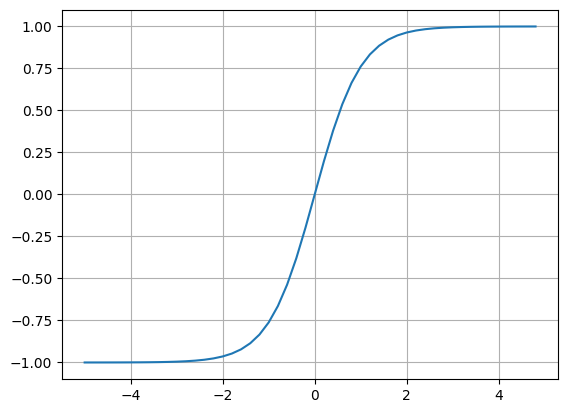

In [11]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

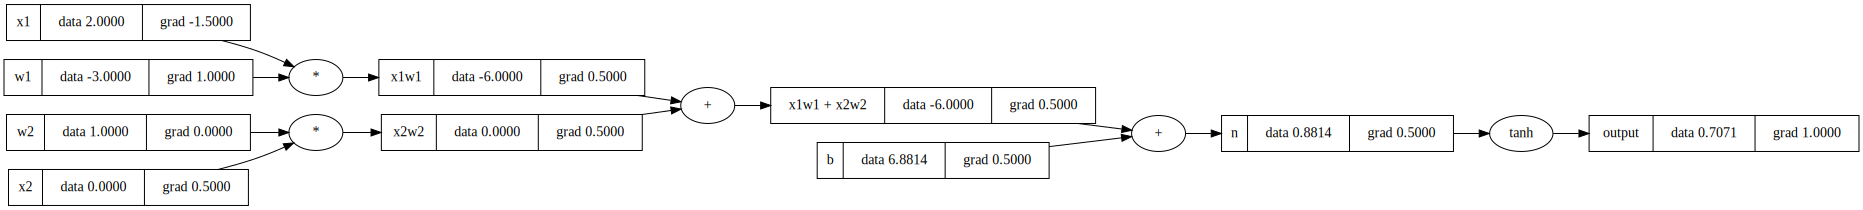

In [12]:
# inputs - 2d neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights - like the synaptic strings for each input
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.8813735870195432, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b
n.label = "n"  # the output of the neuron without the activation function

output = n.tanh()
output.label = "output"

output.backward()

draw_dot(output)

Since we need to call `._backward()` on all nodes, it's necessary for them to be topologically sorted.

This means that the nodes are sorted in the order that they need to be computed. We can't compute the derivative of a node until we've computed the derivatives of all its children.

Topological sorting is a way to lay out the graph such that edges only go from left to right.

```python
topo = []
visited = set()
def build_topo(v: Value):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # only add itself after all children have been added

build_topo(output)
topo
```

It's important to handle the multivariate case of the chain rule. If a `Value` is used in multiple places in the graph, we need to sum the gradients from all the places it's used, not just take the last one.

That's why we're using `+=` in the `_backward` methods.

## How to do the same thing but in Pytorch
Micrograd is based on scalars, while PyTorch is based on tensors.
Tensors are just multi-dimensional arrays of scalars.

In [13]:
import torch

# Casting to double (float64) because that's what Python uses by default
# Pytorch uses float32 as default so we have to cast to double

# and we have to set requires_grad to True so that Pytorch keeps track of the gradients
# they are leaf nodes, so by default they have no gradients

# we use .item() to get the actual value of the tensor
# because it's just a single value inside the tensor

# pytorch is a lot more efficient than our Value class
# partly because it uses tensors and can do lots of ops in parallel
# (it's implemented in C++ and CUDA)

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
output = torch.tanh(n)

output.backward()

p({
    "output": output.data.item(),
    "x1.grad": x1.grad.item(),
    "w1.grad": w1.grad.item(),
    "x2.grad": x2.grad.item(),
    "w2.grad": w2.grad.item(),
})

output:  0.7071066904050358
x1.grad: -1.5000003851533106
w1.grad: 1.0000002567688737
x2.grad: 0.5000001283844369
w2.grad: 0.0


## Building a Neural Network
The goal is a 2 layer MLP.

In [14]:
import random
from typing import List


class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w.x+b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), start=self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    def __init__(self, nin: int, nouts: List[int]):
        sz = [
            nin
        ] + nouts  # e.g. when we have nin=3 and nouts=[4, 4, 1], sz=[3, 4, 4, 1]
        self.layers = [
            Layer(sz[i], sz[i + 1]) for i in range(len(nouts))
        ]  # create a layer for each pair of sizes
        # e.g. create a layer for 3->4, 4->4, 4->1

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [15]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.23528973269490824, grad=0.0)

In [16]:
# draw_dot(mlp(x))

### Dataset

In [17]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Training
Our initial predictions aren't very close to the actual values. We need to adjust the weights to make our predictions better.

So how do we do that?

We use the loss function to measure how far off our predictions are. We want to minimize the loss function.

We'll use the MSE loss function.

In [18]:
ypred = [mlp(x) for x in xs]
ypred

[Value(data=-0.23528973269490824, grad=0.0),
 Value(data=-0.143851440045126, grad=0.0),
 Value(data=-0.5568747426175676, grad=0.0),
 Value(data=-0.35607999199639484, grad=0.0)]

In [19]:
loss: Value = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.2942440188374515, grad=0.0)

In [20]:
loss.backward()

In [21]:
mlp.layers[0].neurons[0].w[0]

Value(data=0.8768053405457576, grad=0.08343590775061324)

In [22]:
# draw_dot(loss)

In [23]:
print(f"The network has {len(mlp.parameters())} parameters")

The network has 41 parameters


#### Gradient Descent

For each parameter, we want to move it in the direction that decreases the loss function.
This means we want to move it in the direction of the negative gradient.

You can think of the gradient vector as pointing uphill (increasing loss). We want to move in the opposite direction to decrease the loss.

**Learning Rate:** don't set this too high or the network will diverge; the whole thing will get unstable, you might even explode the loss. If it's too low, the network will learn very slowly.

In [24]:
learning_rate = 0.01

for p in mlp.parameters():
    p.data -= learning_rate * p.grad

In [25]:
n_epochs = 1000
learning_rate = 0.05

mlp = MLP(3, [4, 4, 1])

for k in range(n_epochs):
    # Forward pass
    y_pred = [mlp(x) for x in xs]
    loss: Value = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)]) # type: ignore
    
    # Backward pass
    loss.backward()
    
    # Update. This is very simple - in practice we would use an optimizer
    # like Adam or SGD with momentum.
    for p in mlp.parameters():
        p.data -= learning_rate * p.grad
        p.grad = 0.0 # reset the gradients to 0 (zero-grad)

    if k % 100 == 0:
        print(f"Epoch {k} Loss: {loss.data:.4f}")
    elif k == n_epochs - 1:
        print(f"Epoch {k} Loss: {loss.data:.4f}")

Epoch 0 Loss: 5.3436
Epoch 100 Loss: 0.0071
Epoch 200 Loss: 0.0032


Epoch 300 Loss: 0.0020
Epoch 400 Loss: 0.0015
Epoch 500 Loss: 0.0012
Epoch 600 Loss: 0.0009
Epoch 700 Loss: 0.0008
Epoch 800 Loss: 0.0007
Epoch 900 Loss: 0.0006
Epoch 999 Loss: 0.0005


In [26]:
y_pred

[Value(data=0.9886359777984637, grad=-0.022728044403072634),
 Value(data=-0.9847987400873562, grad=0.03040251982528752),
 Value(data=-0.9932409065523544, grad=0.013518186895291162),
 Value(data=0.9880275260701197, grad=-0.023944947859760646)]

## Conclusion

Neural networks are mathematical expressions.
They take as input the data and the network parameters, and they output predictions.

To train them, we start by doing a forward pass, and then compute their loss with a loss function.
This calculates the accuracy of the predictions. The closer you are, the lower the loss (closer to 0).

We then compute the gradients of the loss function w.r.t the network parameters.
This tells us how to adjust the weights to make the loss lower.
We do this by doing a backward pass through the network.

And then we update the weights using the gradients and a learning rate.
We use gradient descent, which is basically just the process of updating the weights to minimize the loss function iteratively.

**Why batches:**
When you have a small dataset, you can just use the whole dataset to compute the gradients.
But for large datasets, you pick up some random subset of the data (call that a batch) and only process (forward, backward, update) that batch.
That way, we don't have to forward the entire training set.